<a href="https://colab.research.google.com/github/Roby290597/nlp_exercise/blob/main/bundestags_reden_analyse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os 
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import requests
from sentence_transformers import SentenceTransformer
import numpy as np  
import sys

In [3]:
import sys
from pathlib import Path

extr = next((str(p/"extr") for p in [Path.cwd()] + list(Path.cwd().parents) if (p/"extr").is_dir()), None)
if extr and extr not in sys.path:
    sys.path.insert(0, extr)
print("extr hinzugefügt zu sys.path:", extr)

from redner_extraction import extract_speeches, extract_all_speakers, get_average_sentiment


extr hinzugefügt zu sys.path: c:\Users\brand\OneDrive\Desktop\AI_Selbststudium\ML_little\bundestag_reden\extr


Device set to use cpu


### Extraction of bundestag data  

In [4]:
# Füge Parent-Dir von `extr` zu sys.path hinzu, damit z.B. config.yaml gefunden werden kann
parent_dir = str(Path(extr).parent)
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
print("Parent-Dir hinzugefügt zu sys.path:", parent_dir)

print(os.listdir(parent_dir))


import yaml
# Load YAML data
with open(parent_dir + "\\config.yaml", "r") as file:
    data = yaml.safe_load(file)  # safe_load prevents arbitrary code execution

# Modify data (optional)
url = data['data']["xml_file"]

Parent-Dir hinzugefügt zu sys.path: c:\Users\brand\OneDrive\Desktop\AI_Selbststudium\ML_little\bundestag_reden
['.git', '.gitignore', 'config.yaml', 'extr', 'fine_tune_summarization.py', 'GPT_fine_tune_summarization.py', 'README.md', 'requirements.txt', 'tasks', 'ToDo.txt', 'web_ui']


In [5]:
#url = "https://www.bundestag.de/resource/blob/1115000/21032.xml" ### Bundestag Reden XML Datei vom November 2025 (Stand 30. November 2025 war es das aktuellste)
response = requests.get(url)

# XML in einen Tree parsen
tree = ET.ElementTree(ET.fromstring(response.content))

# Wurzel-Element abrufen
root = tree.getroot()

In [6]:
reden = {}
redner = []
# Beispiel-Ausgabe
for speech in extract_speeches(root):
    #print(f"Redner: {speech['name']}\nRede: {speech['text'][:200]}...\n")
    if speech['name'] not in redner:
        redner.append(speech['name'])
        reden[speech['name']] = speech['text']
    else:
        print("DOPPELT:", speech['name'])
        reden[speech['name']] += "\n Nächste Rede:" + speech['text']

DOPPELT: Mandy Eißing
DOPPELT: Peter Bohnhof
DOPPELT: Mahmut Özdemir
DOPPELT: Klaus Wiener
DOPPELT: Mirze Edis


In [7]:
redner_party = []
all_speakers = extract_all_speakers(root)
for speaker in all_speakers:
    print(speaker)
    redner_party.append((speaker['vorname'] + " " + speaker['nachname'], speaker['fraktion']))

{'vorname': 'Bärbel', 'nachname': 'Bas', 'fraktion': '', 'rolle_kurz': 'Bundesministerin BMAS'}
{'vorname': 'Hans-Jürgen', 'nachname': 'Goßner', 'fraktion': 'AfD', 'rolle_kurz': ''}
{'vorname': 'Wilfried', 'nachname': 'Oellers', 'fraktion': 'CDU/CSU', 'rolle_kurz': ''}
{'vorname': 'Ricarda', 'nachname': 'Lang', 'fraktion': 'BÜNDNIS\xa090/DIE GRÜNEN', 'rolle_kurz': ''}
{'vorname': 'Pascal', 'nachname': 'Meiser', 'fraktion': 'Die Linke', 'rolle_kurz': ''}
{'vorname': 'Dagmar', 'nachname': 'Schmidt', 'fraktion': 'SPD', 'rolle_kurz': ''}
{'vorname': 'Peter', 'nachname': 'Bohnhof', 'fraktion': 'AfD', 'rolle_kurz': ''}
{'vorname': 'Sandra', 'nachname': 'Carstensen', 'fraktion': 'CDU/CSU', 'rolle_kurz': ''}
{'vorname': 'Armin', 'nachname': 'Grau', 'fraktion': 'BÜNDNIS\xa090/DIE GRÜNEN', 'rolle_kurz': ''}
{'vorname': 'Nora', 'nachname': 'Seitz', 'fraktion': 'CDU/CSU', 'rolle_kurz': ''}
{'vorname': 'Leif-Erik', 'nachname': 'Holm', 'fraktion': 'AfD', 'rolle_kurz': ''}
{'vorname': 'Peter', 'nachn

In [8]:
from transformers import pipeline

# using pipeline API for summarization task
summarization = pipeline("summarization", model="t5-small", tokenizer="t5-small", max_length=1100, min_length=700)

# Just an example text in German
original_text = """

Sehr geehrte/r Frau/Herr [Name],

mit großem Interesse bewerbe ich mich als Bankkaufmann in Ihrem Haus. Ich möchte meine Stärke
 im kundenorientierten Arbeiten, meine Sorgfalt im Umgang mit finanziellen Themen sowie meine 
 Freude an Beratung und Vertrieb in Ihre Filiale/Ihr Team einbringen.
In meiner bisherigen Tätigkeit/ Ausbildung zum Bankkaufmann habe ich Privatkundinnen und -kunden 
im täglichen Bankgeschäft betreut – von Kontoführung und Zahlungsverkehr über Service- und 
Beratungsgespräche bis hin zur Terminvorbereitung für komplexere Finanzthemen. Dabei war mir wichtig, 
verständlich zu kommunizieren, Bedürfnisse sauber zu erfassen und Lösungen zuverlässig umzusetzen.
Besonders schätze ich die Kombination aus persönlicher Beratung, strukturierten Prozessen und 
verantwortungsvollem Arbeiten.
Ich arbeite gewissenhaft, diskret und belastbar – auch bei hohem Kundenaufkommen. 
Gleichzeitig bringe ich Teamgeist mit und lege Wert auf eine saubere Dokumentation 
sowie die Einhaltung regulatorischer Vorgaben. Den Umgang mit gängigen Bank-/Office-Systemen 
beherrsche ich sicher und arbeite mich schnell in neue Tools ein.
Gern überzeuge ich Sie in einem persönlichen Gespräch von meiner Motivation und Eignung. 
Ich freue mich über Ihre Rückmeldung.
Mit freundlichen Grüßen.
Max Mustermann
"""

print(len(original_text))

summary_text = summarization(original_text)[0]['summary_text']
print(summary_text)


from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
scores = scorer.score(original_text, summary_text)
print("ROUGE Scores:", scores)

Device set to use cpu


1308
ich möchte meine Stärke im kundenorientierten Arbeiten, meine Sorgfalt im Umgang mit finanziellen Themen sowie meine Freude an Beratung und Vertrieb in Ihrem Filiale/Ihr Team einbringen. Dabei war mir wichtig, verständlich zu kommunizieren, Bedürfnisse sauber zu erfassen und Lösungen zuverlässig umzusetzen.
ROUGE Scores: {'rouge1': Score(precision=1.0, recall=0.25, fmeasure=0.4), 'rougeL': Score(precision=0.9791666666666666, recall=0.24479166666666666, fmeasure=0.39166666666666666)}


In [9]:
summary_text = summarization(reden["Leif-Erik Holm"][1000:2000])[0]['summary_text']
print("Summary:", summary_text)

Summary: uf der Bremse war ich beim Verband der Familienunternehmer zu Gast, und dieser ruft mittlerweile sehr, sehr laut um Hilfe klagt die Verbandschefin Ostermann . Sie alle sind bitter enttäuscht von dieser Pinocchio-Regierung .


## Calcutation of the rouge score 


A description of the rouge_score is given on this website: https://spotintelligence.com/2024/08/12/rouge-metric-in-nlp/

In [18]:
from rouge_score import rouge_scorer

# Initialisierung des Scorers 
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL', 'rougeLsum'], use_stemmer=True)



precisions_r1 = []
recalls_r1 = []
f1s_r1 = []
length_ratios = []

for name, text in reden.items():
    summary_text = summarization(text)[0]['summary_text']
    scores = scorer.score(text[:1000], summary_text)
    print(f"Redner: {name}\nZusammenfassung: {summary_text} ")
    print(f"ratio of the summarized text to the original: {len(summary_text)/len(text[:1000])}")
    print("ROUGE Scores:", scores["rouge1"])
    precisions_r1.append(scores["rouge1"].precision)
    recalls_r1.append(scores["rouge1"].recall)
    f1s_r1.append(scores["rouge1"].fmeasure)
    length_ratios.append(len(summary_text)/len(text[:1000]))

Redner: Bärbel Bas
Zusammenfassung: wir investieren in Kitas, in Schulen, in Krankenhäuser, in Klimaschutz . wir stärken die kritische Infrastruktur, auch in Zeiten neuartiger Bedrohungen . Wir treiben Forschung und Entwicklung mit Digitalisierung voran . 
ratio of the summarized text to the original: 0.219
ROUGE Scores: <class 'rouge_score.scoring.Score'>
Redner: Hans-Jürgen Goßner
Zusammenfassung: a deutscher Bürokratiepolitik ist wieder einmal ein Paradebeispiel - ein Gesetz, das angeblich für Fairness sorgen soll, in Wahrheit aber vor allem eins ist: ein Bürokrater, das Betriebe gängelt, Unternehmer misstrauisch beäugt und Beamtenstellen sichert . in der Antwort der Bundesregierung auf meine Kleine Anfrage steht nämlich schwarz auf weiß, dass die Bundesregulierung nicht mal weiß, was eine Gewerkschaft überhaupt 
ratio of the summarized text to the original: 0.423
ROUGE Scores: <class 'rouge_score.scoring.Score'>
Redner: Wilfried Oellers
Zusammenfassung: Sehr geehrte Frau Präsidenti

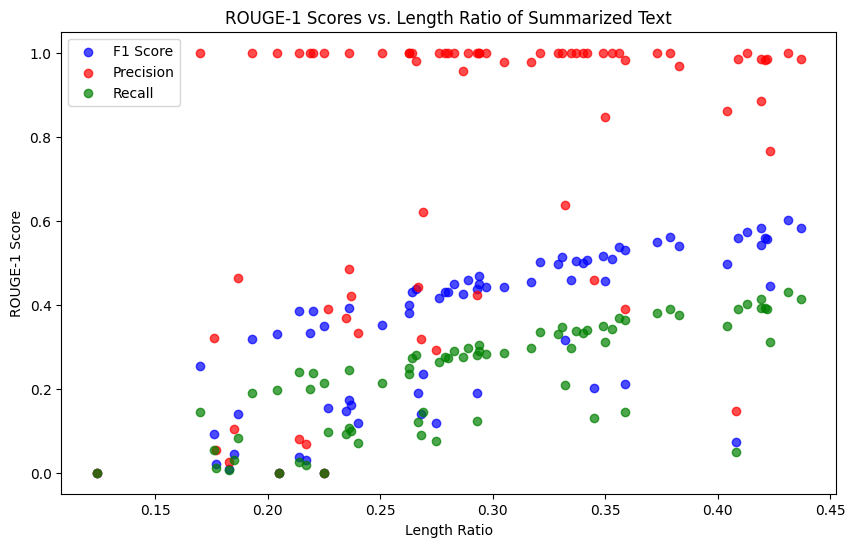

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(length_ratios, f1s_r1, color='blue', alpha=0.7, label='F1 Score')        
plt.scatter(length_ratios, precisions_r1, color='red', alpha=0.7, label='Precision')
plt.scatter(length_ratios, recalls_r1, color='green', alpha=0.7, label='Recall')
plt.title('ROUGE-1 Scores vs. Length Ratio of Summarized Text')
plt.xlabel('Length Ratio')
plt.ylabel('ROUGE-1 Score')
plt.legend()
plt.show()


In [ ]:
from rouge_score import rouge_scorer


senetence1 = "The quick brown fox jumps on the dog !"
senetence2 = "The quick brown fox jumps on the dog."

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2','rougeL'], use_stemmer=True)
scores = scorer.score(senetence1, senetence2)




from transformers import AutoTokenizer

checkpoint = "google-t5/t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)



from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)


prefix = "summarize: "


{'rouge1': Score(precision=1.0, recall=0.6666666666666666, fmeasure=0.8),
 'rouge2': Score(precision=1.0, recall=0.6363636363636364, fmeasure=0.7777777777777778),
 'rougeL': Score(precision=1.0, recall=0.6666666666666666, fmeasure=0.8)}

In [50]:
from datasets import load_dataset


prefix = "summarize: "


def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["text"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)

    labels = tokenizer(text_target=examples["summary"], max_length=128, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


billsum = load_dataset("billsum", split="ca_test")
billsum = billsum.train_test_split(test_size=0.9)
tokenized_billsum = billsum.map(preprocess_function, batched=True)

Map: 100%|██████████| 1114/1114 [00:02<00:00, 475.21 examples/s]


In [61]:
billsum = load_dataset("billsum", split="ca_test")


In [ ]:
billsum = billsum.train_test_split(test_size=0.999)

tokenized_billsum = billsum.map(preprocess_function, batched=True)

AttributeError: 'DatasetDict' object has no attribute 'train_test_split'